In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
import tensorflow as tf
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
!unzip -q "/content/gdrive/My Drive/face_mask_detection (1).zip" -d "/content/gdrive/My Drive/mask_detection"

In [24]:
train_df=pd.read_csv('/content/gdrive/My Drive/mask_detection/face_mask_detection/Training_set_face_mask.csv')
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory='/content/gdrive/My Drive/mask_detection/face_mask_detection/train', 
    x_col='filename',
    y_col='label',
    subset='training',
    target_size=(224, 224),
    batch_size=20,
    shuffle=True
)
val_generator = val_datagen.flow_from_dataframe(
    train_df, 
    directory='/content/gdrive/My Drive/mask_detection/face_mask_detection/train', 
    x_col='filename',
    y_col='label',
    subset='validation',
    target_size=(224, 224),
    batch_size=20,
    shuffle=True
)



Found 9012 validated image filenames belonging to 2 classes.
Found 2252 validated image filenames belonging to 2 classes.


In [25]:
test_df=pd.read_csv('/content/gdrive/My Drive/mask_detection/face_mask_detection/Testing_set_face_mask.csv')
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    directory='/content/gdrive/My Drive/mask_detection/face_mask_detection/test', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=20,
    shuffle=False
)

Found 1536 validated image filenames.


In [18]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

model.compile(loss="binary_crossentropy", optimizer=Adam(1e-4),
	metrics=["accuracy"])

In [26]:
history = model.fit(
            train_generator,
            validation_data = val_generator,
            epochs = 50,
            verbose = 1,
            callbacks=callbacks
            )

Epoch 1/50
451/451 [==============================] - 116s 258ms/step - loss: 0.2297 - accuracy: 0.9078 - val_loss: 0.0880 - val_accuracy: 0.9707
Epoch 2/50
451/451 [==============================] - 116s 256ms/step - loss: 0.0997 - accuracy: 0.9644 - val_loss: 0.0737 - val_accuracy: 0.9711
Epoch 3/50
451/451 [==============================] - 116s 257ms/step - loss: 0.0822 - accuracy: 0.9730 - val_loss: 0.0446 - val_accuracy: 0.9836
Epoch 4/50
451/451 [==============================] - 116s 257ms/step - loss: 0.0696 - accuracy: 0.9737 - val_loss: 0.0347 - val_accuracy: 0.9871
Epoch 5/50
451/451 [==============================] - 115s 255ms/step - loss: 0.0606 - accuracy: 0.9791 - val_loss: 0.0310 - val_accuracy: 0.9898
Epoch 6/50
451/451 [==============================] - 116s 256ms/step - loss: 0.0606 - accuracy: 0.9794 - val_loss: 0.0278 - val_accuracy: 0.9893
Epoch 7/50
451/451 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9808
Epoch 00007: ReduceLROnPlate

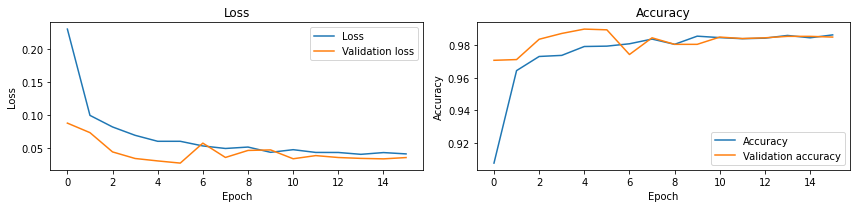

In [30]:
f, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(history.history['loss'], label="Loss")
ax[0].plot(history.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

        # Accuracy
ax[1].plot(history.history['accuracy'], label="Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [32]:
predict = model.predict(test_generator)
test_df['label'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)
test_df['label']="'"+test_df['target']+"'"

In [38]:
test_df['label']="'"+test_df['label']+"'"
test_df.tail()

,filename,label
1531,Image_1532.jpg,'with_mask'
1532,Image_1533.jpg,'with_mask'
1533,Image_1534.jpg,'with_mask'
1534,Image_1535.jpg,'with_mask'
1535,Image_1536.jpg,'without_mask'


In [39]:
test_df.to_csv('submission_face_mask.csv', index=False)
from google.colab import files
files.download('submission_face_mask.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>